Although EDRIXS can work with different basis sets, the default is the complex harmonic basis $Y^m_l$ where $m$
goes from $-l,-l+1,...,l-1, l$. There is an up spin and a down spin for each $Y^m_l$.

Here we outline how to convert from the $J$, $J_z$ basis used by the McPhase software into this EDRIXS form. 
See appendix B of the [McPhase Manual](https://www2.cpfs.mpg.de/~rotter/homepage_mcphase/manual/node132.html) for details.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import edrixs

from angular_momentum import cf_stevens, J2LS

# Convert from ($J$, $J_z$) basis to $LS$ basis

In [2]:
# input B (Stevens parameters) in the (J,Jz) basis obtained from McPhase calculations by Lazar Kish.
B = {}
B[0] = {0: 48387.1}
B[2] = {-2: -3.40812, 0: -0.88772, 2: 1.00403}
B[4] = {-4: -0.0748436, -2: 0.0378936, 0: 0.0018281, 2: 0.00956521, 4:-0.00386599}
B[6] = {-6: -1.19749e-005, -4: 5.87608e-005, -2: -0.000362445, 0: -8.43923e-005, 
        2: 0.000222451, 4:-0.00198476, 6: 0.000240476}

In [3]:
# convert B into LS basis and print
B_LS = J2LS('Yb3+', B)
for k in B_LS:
    for m in B_LS[k]:
        print("B_LS[{:d}][{:d}] = {:.4e}".format(k,m,B_LS[k][m]))

B_LS[0][0] = 4.8387e+04
B_LS[2][-2] = -4.7714e+00
B_LS[2][0] = -1.2428e+00
B_LS[2][2] = 1.4056e+00
B_LS[4][-4] = -1.7464e-01
B_LS[4][-2] = 8.8418e-02
B_LS[4][0] = 4.2656e-03
B_LS[4][2] = 2.2319e-02
B_LS[4][4] = -9.0206e-03
B_LS[6][-6] = -8.3824e-05
B_LS[6][-4] = 4.1133e-04
B_LS[6][-2] = -2.5371e-03
B_LS[6][0] = -5.9075e-04
B_LS[6][2] = 1.5572e-03
B_LS[6][4] = -1.3893e-02
B_LS[6][6] = 1.6833e-03


In [4]:
# calculate the crystal field matrix in electron lanuage based on the converted Stevens parameters
L = 3
H_LS = cf_stevens(L, B_LS)*-1/1000 # 
v_cfmat = np.zeros((14, 14), dtype=complex)
v_cfmat[::2, ::2] = H_LS
v_cfmat[1::2, 1::2] = H_LS

v_soc = (0.363026, 0.363026)
c_soc = 19.3913
gamma_c = 0.6
gamma_f = 0.005
thin = np.deg2rad(30)
thout = np.deg2rad(150 - 30)
pol_type = [('linear', 0)]
pol_type_rixs = [('linear', 0, 'linear', 0), ('linear', 0, 'linear', np.pi/2)]
gs_list = list(range(14))
temperature = 30

ominc = np.linspace(1500, 1600, 10000)
eloss = np.linspace(-0.25, 1.5, 10000)

edrixs >>> Running ED ...

    Summary of Slater integrals:
    ------------------------------
    Terms,   Initial Hamiltonian,  Intermediate Hamiltonian
     F0_vv :          0.0000000000        0.0000000000
     F2_vv :          0.0000000000        0.0000000000
     F4_vv :          0.0000000000        0.0000000000
     F6_vv :          0.0000000000        0.0000000000
     F0_vc :          0.0000000000        0.0000000000
     F2_vc :          0.0000000000        0.0000000000
     F4_vc :          0.0000000000        0.0000000000
     G1_vc :          0.0000000000        0.0000000000
     G3_vc :          0.0000000000        0.0000000000
     G5_vc :          0.0000000000        0.0000000000
     F0_cc :          0.0000000000        0.0000000000
     F2_cc :          0.0000000000        0.0000000000
     F4_cc :          0.0000000000        0.0000000000

edrixs >>> Dimension of the initial Hamiltonian:  14
edrixs >>> Dimension of the intermediate Hamiltonian:  10
edrixs >>> Buildin

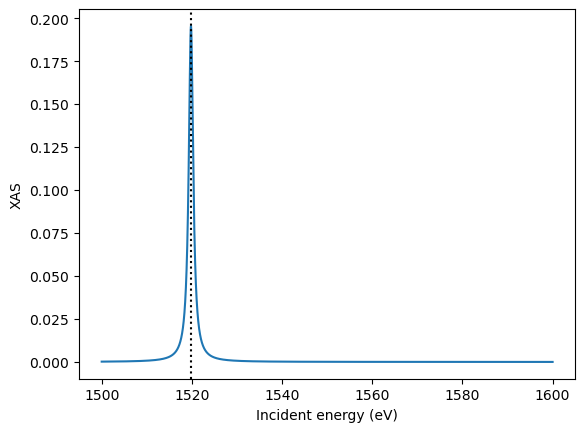

In [5]:
off = 1587
out = edrixs.ed_1v1c_py(('f', 'd'), shell_level=(0, -off), v_soc=v_soc,
                        v_cfmat=v_cfmat,
                        c_soc=c_soc, v_noccu=13)
eval_i, eval_n, trans_op = out

xas = edrixs.xas_1v1c_py(
    eval_i, eval_n, trans_op, ominc, gamma_c=gamma_c,
    thin=thin, pol_type=pol_type,
    gs_list=gs_list, temperature=temperature)

res = ominc[np.argmax(xas.sum(-1))]

fig, ax = plt.subplots()
ax.plot(ominc, xas.sum(-1))
ax.axvline(res, color='k', linestyle=':')
ax.set_xlabel('Incident energy (eV)')
ax.set_ylabel('XAS')
plt.show()

In [6]:
E = np.round(1000*(eval_i - eval_i.min()), 4)
print(f"Eigenenergies in meV\n{E}")

Eigenenergies in meV
[   0.        0.       11.1997   11.1997   31.4109   31.4109   83.0511
   83.0511 1272.685  1272.685  1288.8853 1288.8853 1345.3206 1345.3206]


edrixs >>> Running RIXS ... 
edrixs >>> RIXS Done !


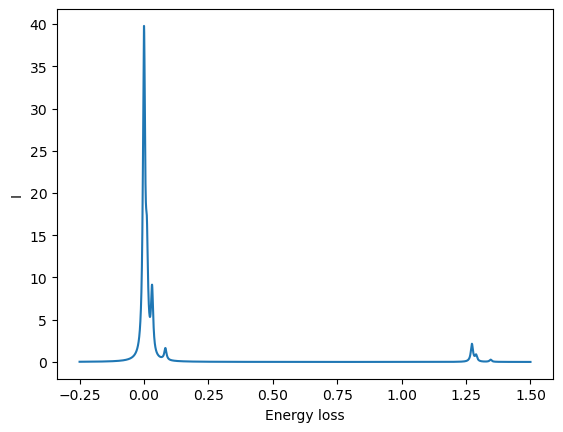

In [7]:
rixs = edrixs.rixs_1v1c_py(
    eval_i, eval_n, trans_op, np.array([res]), eloss,
    gamma_c=gamma_c, gamma_f=gamma_f,
    thin=thin, thout=thout, 
    pol_type=pol_type_rixs, gs_list=gs_list,
    temperature=temperature)

rixs_cut = rixs[0].sum(-1)

fig, ax = plt.subplots()

np.savetxt('YbRIXS.txt', np.vstack([eloss, rixs_cut]).T, header="Energy loss (eV) \t intensity")

ax.plot(eloss, rixs_cut)
ax.set_xlabel('Energy loss')
ax.set_ylabel('I')
plt.show()